In [1]:
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
params = {# Line styles
    'lines.linewidth': 1.5,
    'lines.antialiased': True,

    # Font
    'font.size': 16.0,

    # Axes
    'axes.linewidth': 1.5,
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',

    # Ticks
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'xtick.direction': 'in',
    'xtick.top': True,

    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'ytick.direction': 'in',
    'ytick.right': True,

    # Legend
    'legend.fancybox': True,
    'legend.fontsize': 'large',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',

    # Figure
    'figure.figsize': [8, 6],
    'figure.titlesize': 'large',

    # Images
    'image.cmap': 'magma',
    'image.origin': 'lower',

    # Saving
    'savefig.bbox': 'tight',
    'savefig.format': 'png'}
plt.rcParams.update(params)
from matplotlib import gridspec
from sklearn.datasets import make_spd_matrix
import emcee
import time
from tqdm import tqdm
import zeus
print('zeus version :', zeus.__version__)

zeus version : 0.9.9


In [53]:
ndim = 50
nwalkers = 2 * ndim * 1
ntotal = 5000000
nsteps = int(ntotal / nwalkers)
nplot = 1000
print(nsteps)


def logprior(x):
    if -4.0 <= x[0] <= 4.0 and np.all(x[1:]<=30) and np.all(x[1:]>=-30):
        return 0.0
    else:
        return -np.inf

def loglikelihood(x):
    a = 1.0
    b = 0.5
    first = -0.5*(x[0]**2.0 / a**2.0) - 0.5 * np.log(2.0 * np.pi) - np.log(a)
    rest = -0.5*np.sum(x[1:]**2.0 / np.exp(2*b*x[0])) -0.5*np.log(2.0 *np.pi) - (ndim-1) * b * x[0]
    return first + rest

def logp(x):
    return loglikelihood(x) #+ logprior(x)

deviation = np.zeros(ndim)
deviation[0] = 3.0
#deviation[1] = 10.0


start = 1.0 * np.random.randn(nwalkers,ndim) + deviation

50000


Initialising ensemble of 100 walkers...
Sampling progress : 100%|██████████| 50000/50000 [07:25<00:00, 112.16it/s]


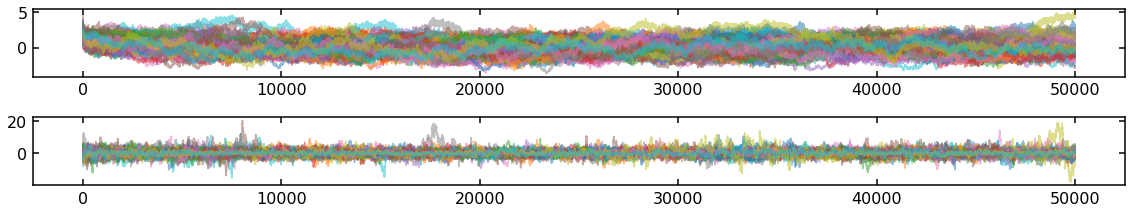

Summary
-------
Number of Generations: 50000
Number of Parameters: 50
Number of Walkers: 100
Mean Integrated Autocorrelation Time: 199.53
Effective Sample Size: 25058.41
Number of Log Probability Evaluations: 26422644.0
Effective Samples per Log Probability Evaluation: 0.000948


9461
thin by 473
(1100, 50)


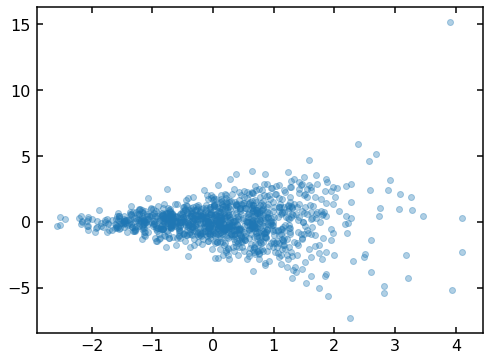

In [54]:
sampler_zeus = zeus.sampler(logp, nwalkers, ndim, mu=3.0, jump=0.0, tune=True)
sampler_zeus.run(start, nsteps)

plt.figure(figsize=(16,1.5*ndim))
for n in range(2):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(np.arange(np.shape(sampler_zeus.chain)[1]),sampler_zeus.chain[:,:,n].T,alpha=0.5)
plt.tight_layout()
plt.show()

sampler_zeus.summary

maximum = int(ntotal/sampler_zeus.ncall * nsteps)
print(maximum)

thin_zeus = int(maximum/2.0 * nwalkers / nplot )
print('thin by', thin_zeus)

trace_zeus = sampler_zeus.chain[:,int(maximum/2.0):maximum:thin_zeus,:].reshape((-1,ndim), order='F')
print(trace_zeus.shape)

plt.scatter(trace_zeus[:,0],trace_zeus[:,1], alpha=0.35)
plt.show()

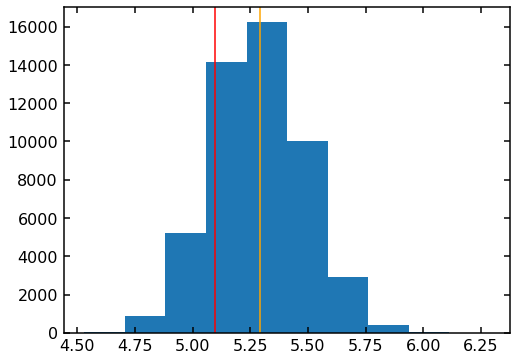

5.2935828


In [55]:
mean_mu = np.mean(sampler_zeus.neval[int(nsteps/2):]/nwalkers)
std_mu = np.std(sampler_zeus.neval[int(nsteps/2):]/nwalkers)

plt.hist(sampler_zeus.neval/nwalkers)
plt.axvline(x=mean_mu, color='orange')
plt.axvline(x=mean_mu - std_mu, color='red')
plt.show()

print(mean_mu)

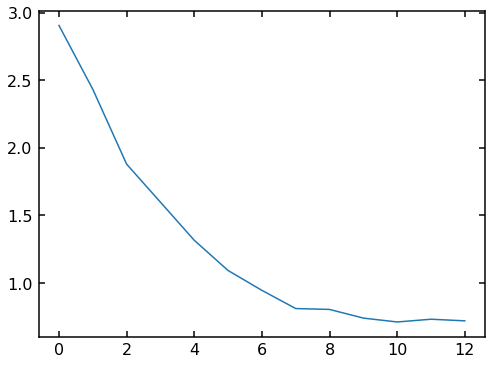

In [56]:
plt.plot(np.arange(len(sampler_zeus.mus)),sampler_zeus.mus)
plt.show()

100%|██████████| 50000/50000 [01:33<00:00, 536.98it/s]


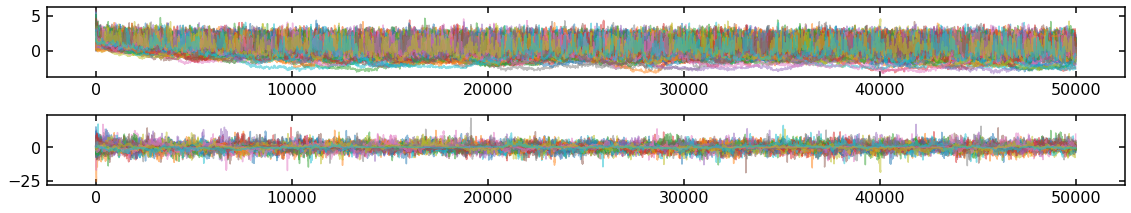

thin by 2500
(1000, 50)


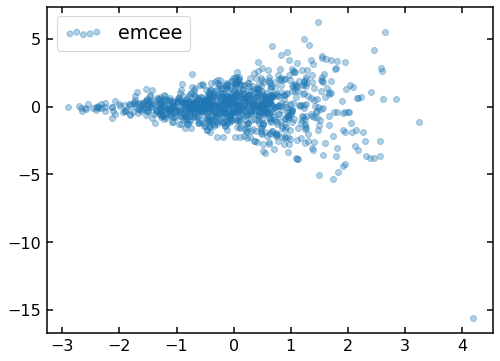

In [57]:
sampler_emcee = emcee.EnsembleSampler(nwalkers, ndim, logp)
sampler_emcee.run_mcmc(start, nsteps, progress=True);
    
plt.figure(figsize=(16,1.5*ndim))
for n in range(2):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(np.arange(np.shape(sampler_emcee.chain)[1]),sampler_emcee.chain[:,:,n].T,alpha=0.5)
plt.tight_layout()
plt.show()

thin_emcee = int(nsteps/2 * nwalkers / nplot)
print('thin by', thin_emcee)

trace_emcee = sampler_emcee.chain[:,int(nsteps/2)::thin_emcee,:].reshape((-1,ndim), order='F')
print(trace_emcee.shape)

plt.scatter(trace_emcee[:,0],trace_emcee[:,1], alpha=0.35, label='emcee')
plt.legend()
plt.show()

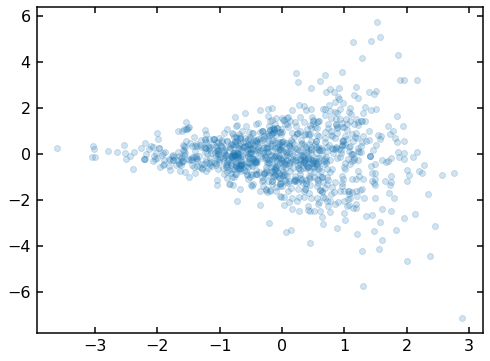

In [58]:
# Independent samples

y_indep = np.random.normal(0.0,1.0,size=nplot)
x_indep = np.empty((nplot,ndim-1))
for i in range(nplot):
    for n in range(ndim-1):
        x_indep[i,n] = np.random.normal(0.0,np.exp(y_indep[i]/2))
        
plt.scatter(y_indep,x_indep.T[0], alpha=0.2)
plt.show()

In [59]:
class Metropolis:
    def __init__(self, logp, ndim):
        self.logp = logp
        self.ndim = ndim
        
    def run(self, start, nsteps, covariance=None):
        self.X = np.copy(start)
        self.nsteps = nsteps
        self.samples = np.empty((self.nsteps, self.ndim))
        self.Y = self.logp(self.X)
        
        if covariance is None:
            cov = np.identity(self.ndim) / self.ndim
        else:
            cov = covariance / self.ndim * 2.38 ** 2.0
            
        proposals = np.random.multivariate_normal(np.zeros(self.ndim),cov,size=self.nsteps)
        
        for i in tqdm(range(self.nsteps)):
            X_prime = self.X + proposals[i]
            Y_prime = self.logp(X_prime)
            
            alpha = min(1.0, np.exp(Y_prime - self.Y))
            u = np.random.uniform(0.0,1.0)
            if u < alpha:
                self.X = np.copy(X_prime)
                self.Y = np.copy(Y_prime)
                
            self.samples[i] = np.copy(self.X)

100%|██████████| 50000/50000 [00:01<00:00, 37921.16it/s]


thin by 2500


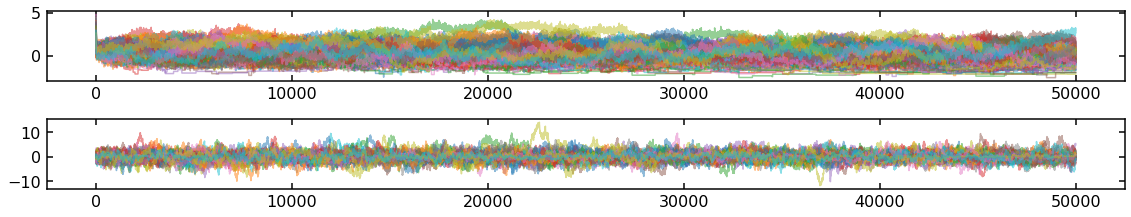

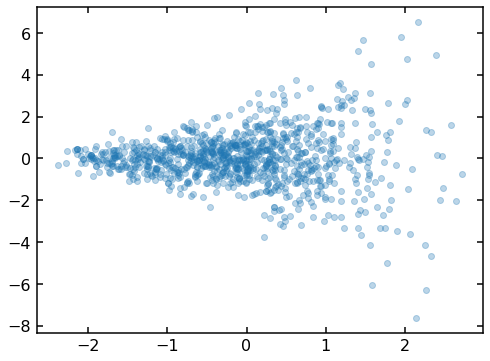

In [60]:
def logprob(x):
    return logp(x)

samples_metropolis_list = []

for p0 in start:
    sampler_metropolis = Metropolis(logprob, ndim)
    sampler_metropolis.run(start=p0, nsteps=nsteps, covariance=np.identity(ndim))
    samples_metropolis_list.append(sampler_metropolis.samples)
    
samples_metropolis = np.asarray(samples_metropolis_list)

thin_metropolis = int(nsteps/2.0 * nwalkers / nplot )
print('thin by', thin_metropolis)

trace_metropolis = samples_metropolis[:,int(nsteps/2.0)::thin_metropolis,:].reshape((-1,ndim),order='F')

plt.figure(figsize=(16,1.5*ndim))
for n in range(2):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(np.arange(np.shape(samples_metropolis)[1]),samples_metropolis[:,:,n].T,alpha=0.5)
plt.tight_layout()
plt.show()

plt.scatter(trace_metropolis[:,0],trace_metropolis[:,1], alpha=0.3)
plt.show()

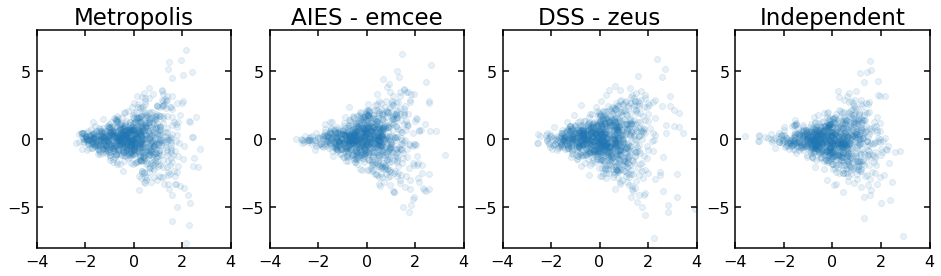

In [61]:
x = 0
y = 1

xmin = -4.0
xmax = 4.0
ymin = -8.0
ymax = 8.0

alpha = 0.1

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.title('Metropolis')
plt.scatter(trace_metropolis[:,x],trace_metropolis[:,y], alpha=alpha)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.subplot(142)
plt.title('AIES - emcee')
plt.scatter(trace_emcee[:,x],trace_emcee[:,y], alpha=alpha)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.subplot(143)
plt.title('DSS - zeus')
plt.scatter(trace_zeus[:,x],trace_zeus[:,y], alpha=alpha)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.subplot(144)
plt.title('Independent')
plt.scatter(y_indep,x_indep.T[0], alpha=alpha)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.gca().set_rasterization_zorder(1)
plt.savefig('comparison_funnel'+str(ndim)+'_'+str(ntotal)+'.pdf', dpi=200)
plt.show()

In [62]:
np.mean(trace_zeus[:,0])

0.1702967762112501

In [63]:
np.mean(trace_emcee[:,0])

0.01604650243196118

In [64]:
np.mean(trace_metropolis[:,0])

-0.08861488797846886

In [65]:
np.mean(y_indep)

-0.025231194732971078

In [66]:
np.std(trace_zeus[:,0])

1.026943650339448

In [67]:
np.std(trace_emcee[:,0])

1.005072991559547

In [68]:
np.std(trace_metropolis[:,0])

0.9862889551681058

In [69]:
np.std(y_indep)

0.9976412469845255

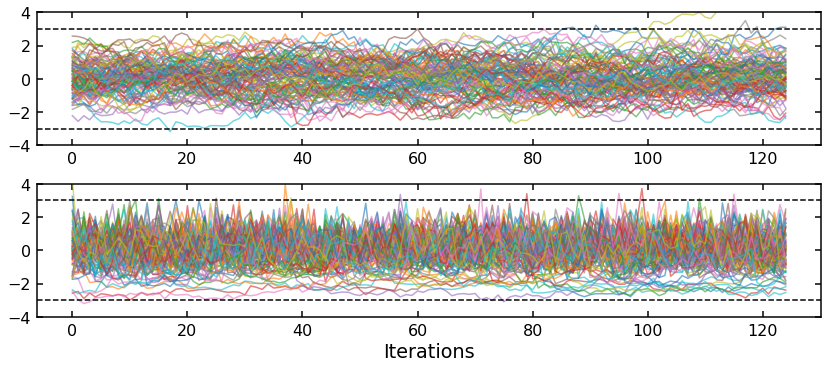

In [70]:
reducted_chain_zeus = sampler_zeus.chain[:,-10000::80,0]
reducted_chain_emcee = sampler_emcee.chain[:,-10000::80,0]


plt.figure(figsize=(12,5))
plt.subplot(211)
plt.plot(np.arange(np.shape(reducted_chain_zeus)[1]),reducted_chain_zeus.T,alpha=0.6)
plt.axhline(y=-3.0,linestyle='--', color='black')
plt.axhline(y=3.0,linestyle='--', color='black')
plt.ylim(-4.0,4.0)
plt.subplot(212)
plt.plot(np.arange(np.shape(reducted_chain_emcee)[1]),reducted_chain_emcee.T,alpha=0.6)
plt.axhline(y=-3.0,linestyle='--', color='black')
plt.axhline(y=3.0,linestyle='--', color='black')
plt.ylim(-4.0,4.0)
plt.tight_layout()
plt.xlabel('Iterations')
plt.show()

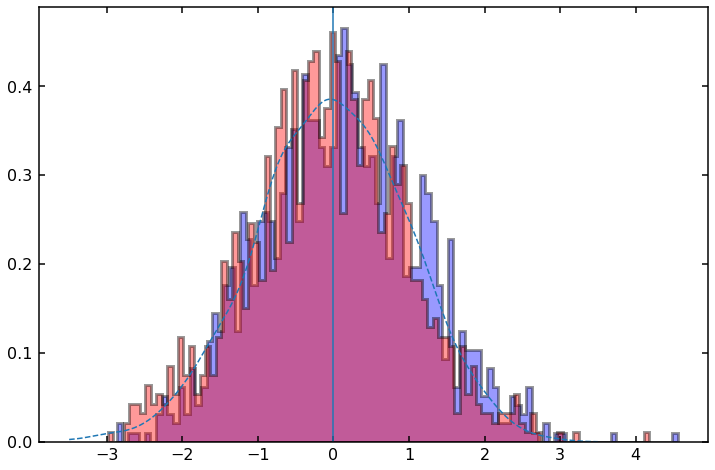

In [71]:
from scipy import stats


indep_den = stats.gaussian_kde(y_indep)


x = np.linspace(-3.5,3.5,1000)

plt.figure(figsize=(12,8))
plt.hist(reducted_chain_zeus[:,::10].flatten(),bins=100, density=True, color='blue',
                 histtype='stepfilled', edgecolor='black', lw=3, alpha=0.4)
plt.hist(reducted_chain_emcee[:,::10].flatten(),bins=100, density=True, color='red',
                 histtype='stepfilled', edgecolor='black', lw=3, alpha=0.4)


plt.plot(x, indep_den(x), '--')
plt.axvline(x=0.0)
plt.show()

In [72]:
np.percentile(trace_zeus[:,0],[16,50,84])

array([-0.84093481,  0.1561637 ,  1.13872625])

In [73]:
np.percentile(trace_emcee[:,0],[16,50,84])

array([-0.95356636,  0.00694406,  0.98191184])